In [28]:
%load_ext autoreload
%autoreload 2

In [29]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.dataset import *
from utils.layerwise import save_pairwise_distances, save_layerwise_plots

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [31]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),
    'audio_encoder.base.conv_block2': nn.Identity(),
    'audio_encoder.base.conv_block3': nn.Identity(),
    'audio_encoder.base.conv_block4': nn.Identity(),
    'audio_encoder.base.conv_block5': nn.Identity(),
    'audio_encoder.base.conv_block6': nn.Identity(),
    'audio_encoder.base.fc1': F.relu,
    'audio_encoder.projection.linear1': F.gelu,
    'audio_encoder.projection.linear2': nn.Identity(),
}

module_list = list(module_activation_dict.keys())

In [32]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [33]:
seed_everything(42)

In [34]:
dataset = NSynthDataset(classes='note_names', class_limit=150)

In [35]:
y_labels = []
for _, _, one_hot in dataset:
    y_labels.append(one_hot.detach().cpu().numpy())

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
class_indices = np.argmax(y_labels, axis=1)

In [37]:
layer_name = module_list[0]
dist = squareform(np.load(f'/scratch/pratyaksh.g/nsynth/pdist/{layer_name}.npy'))
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='precomputed')

In [38]:
confusions = []

In [39]:
dataset.classes

['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

In [40]:
for train, test in skf.split(dist, class_indices):
    knn.fit(dist[train][:, train], class_indices[train])

    pred = knn.predict(dist[test][:, train])
    target = class_indices[test]

    confusions.append(confusion_matrix(target, pred))

Text(0.5, 1.05, 'Confusion matrices for 5-fold cross-validation for note_name classification on NSynth (k=5)')

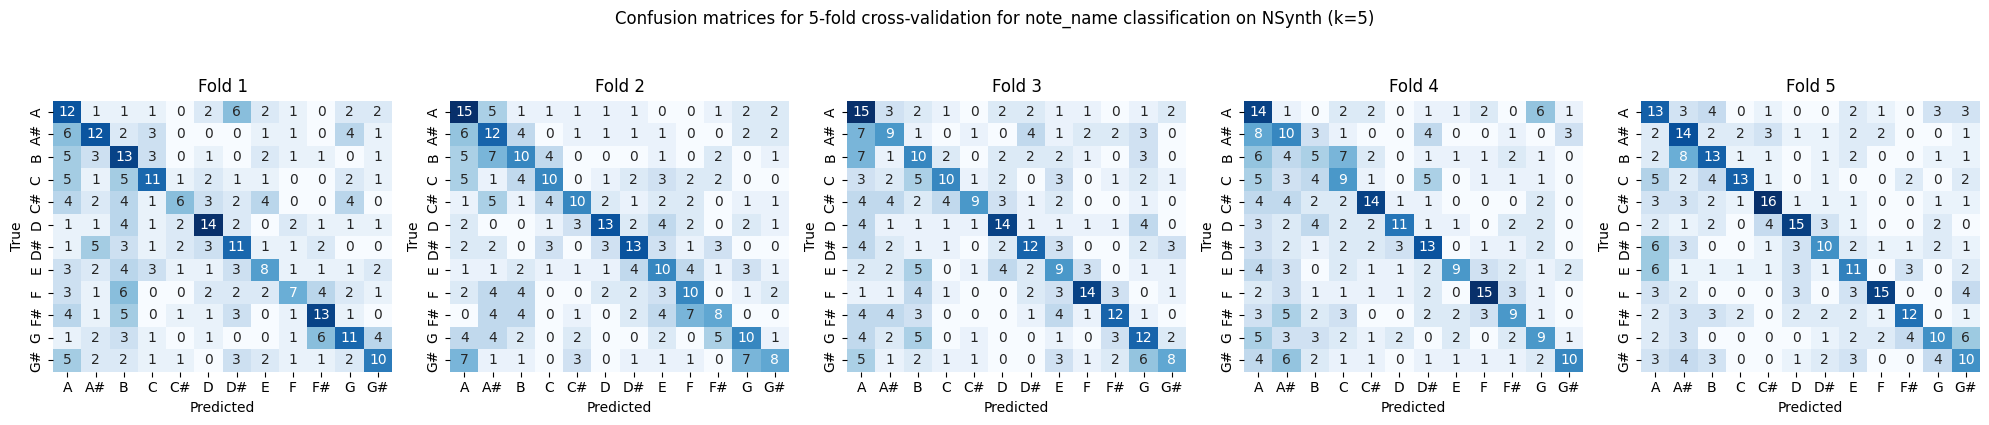

In [41]:
# Make a faceted plot of the confusion matrices using seaborn
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    sns.heatmap(confusions[i], ax=ax, annot=True, fmt='d', cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(dataset.classes)
    ax.set_yticklabels(dataset.classes)
    ax.set_title(f'Fold {i+1}')

fig.set_tight_layout(True)
fig.suptitle('Confusion matrices for 5-fold cross-validation for note_name classification on NSynth (k=5)', y=1.05)

In [42]:
### SCRATCH

In [43]:
import pickle as pkl

In [44]:
dataset_path_name = 'nsynth'

In [45]:
with open(f'/scratch/pratyaksh.g/{dataset_path_name}/plots/accuracy-vs-layer-dataframe.pkl', 'rb') as f:
    df = pkl.load(f)
df

,k,Layer,Accuracy
0,1,audio_encoder.base.conv_block1,0.468889
1,1,audio_encoder.base.conv_block2,0.305000
2,1,audio_encoder.base.conv_block3,0.238333
3,1,audio_encoder.base.conv_block4,0.231667
4,1,audio_encoder.base.conv_block5,0.208333
...,...,...,...
103,100,audio_encoder.base.conv_block5,0.080556
104,100,audio_encoder.base.conv_block6,0.086111
105,100,audio_encoder.base.fc1,0.097222
106,100,audio_encoder.projection.linear1,0.093889


k
1      AxesSubplot(0.125,0.11;0.775x0.77)
2      AxesSubplot(0.125,0.11;0.775x0.77)
3      AxesSubplot(0.125,0.11;0.775x0.77)
4      AxesSubplot(0.125,0.11;0.775x0.77)
5      AxesSubplot(0.125,0.11;0.775x0.77)
6      AxesSubplot(0.125,0.11;0.775x0.77)
7      AxesSubplot(0.125,0.11;0.775x0.77)
8      AxesSubplot(0.125,0.11;0.775x0.77)
9      AxesSubplot(0.125,0.11;0.775x0.77)
20     AxesSubplot(0.125,0.11;0.775x0.77)
50     AxesSubplot(0.125,0.11;0.775x0.77)
100    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

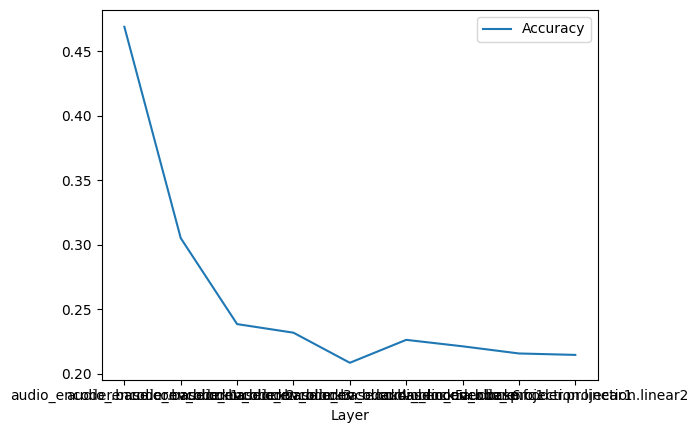

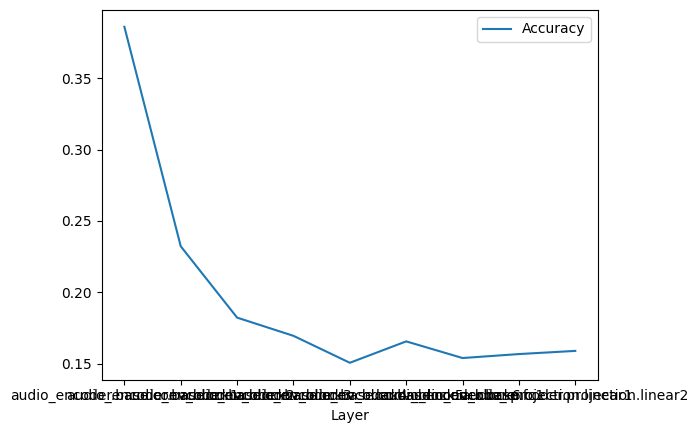

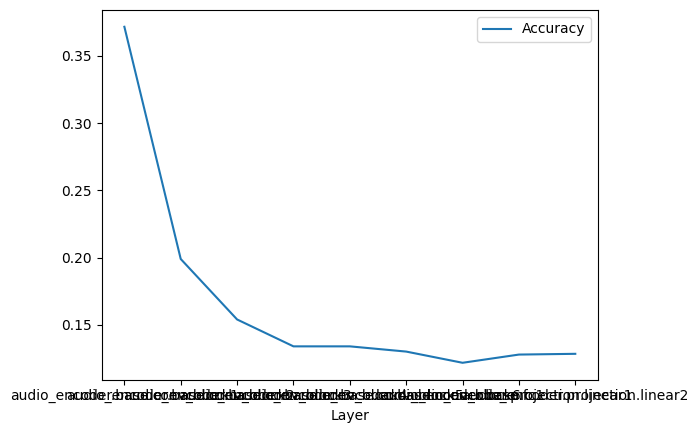

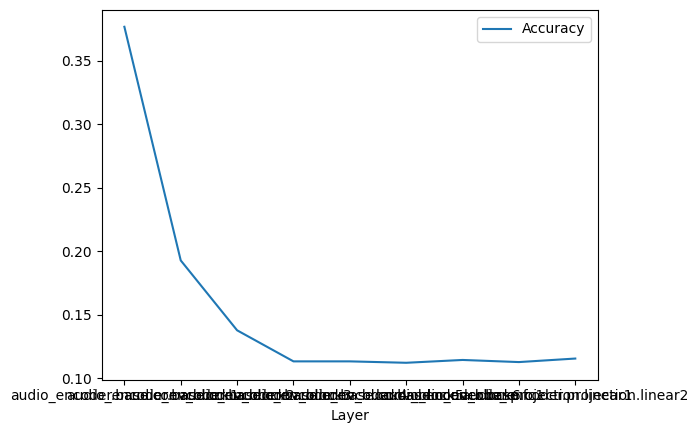

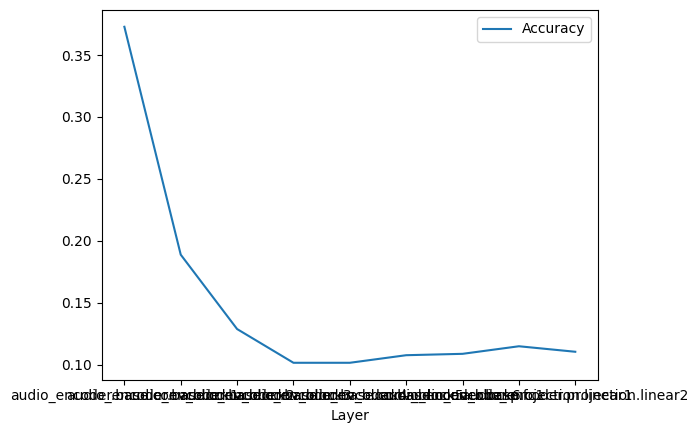

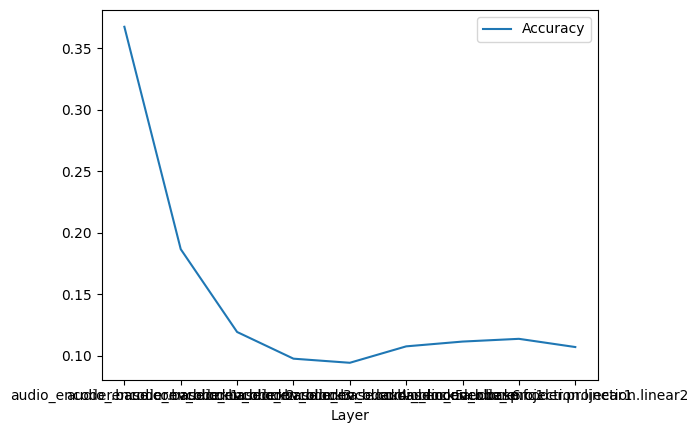

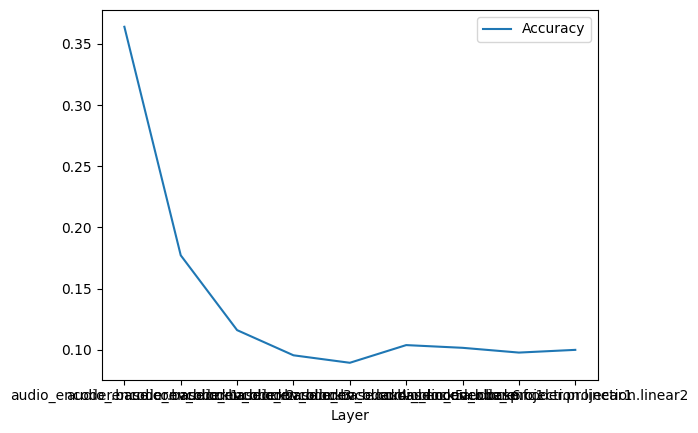

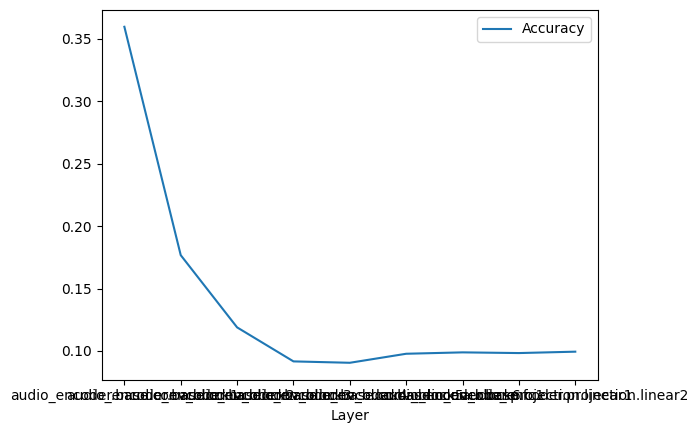

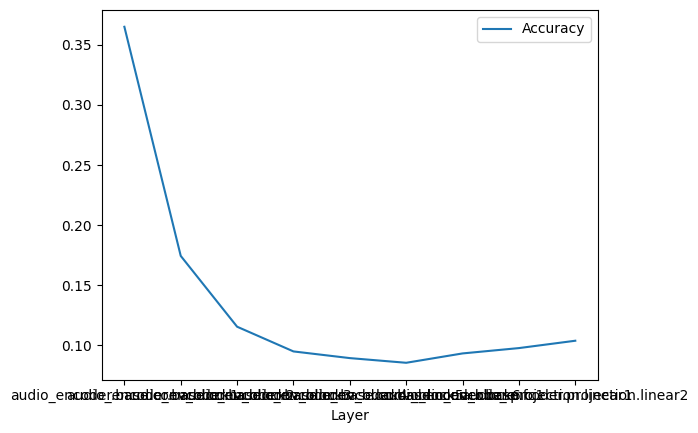

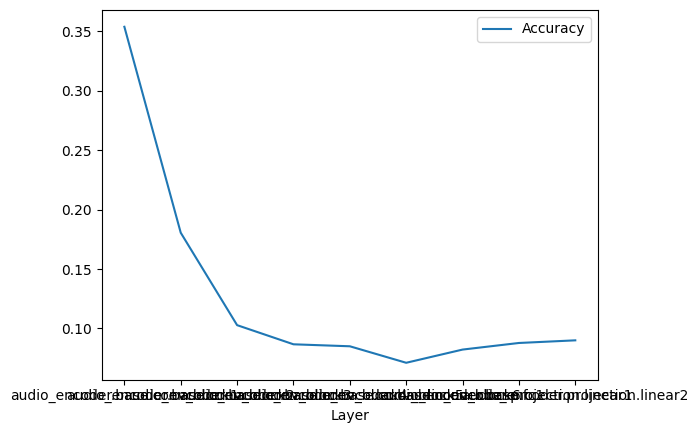

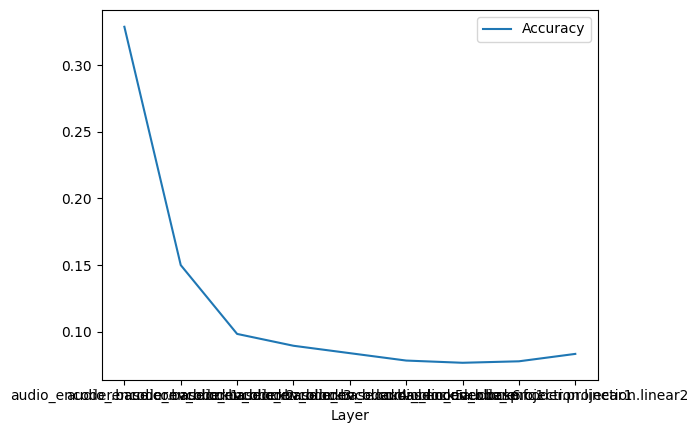

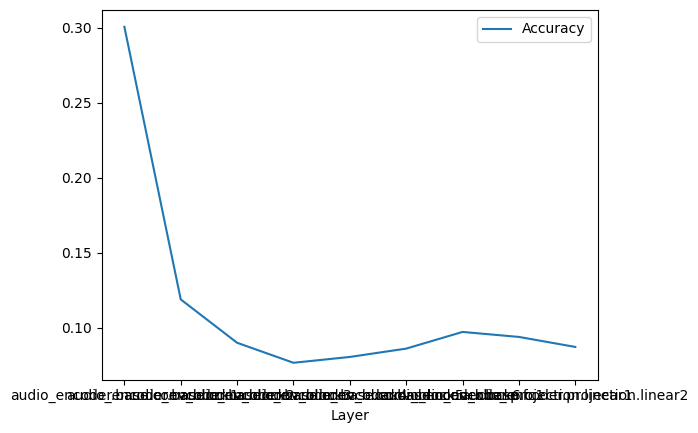

In [46]:
df.groupby('k').plot(x='Layer', y='Accuracy')